In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe
import os  # Import os for file handling
import warnings
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.stats import pearsonr

# 2. Run Unit Tests

C:\Users\asatt\AppData\Local\Temp\ipykernel_6824\2404306254.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_streamflow['discharge_cms'] = filtered_streamflow['observation'] * 0.0283168


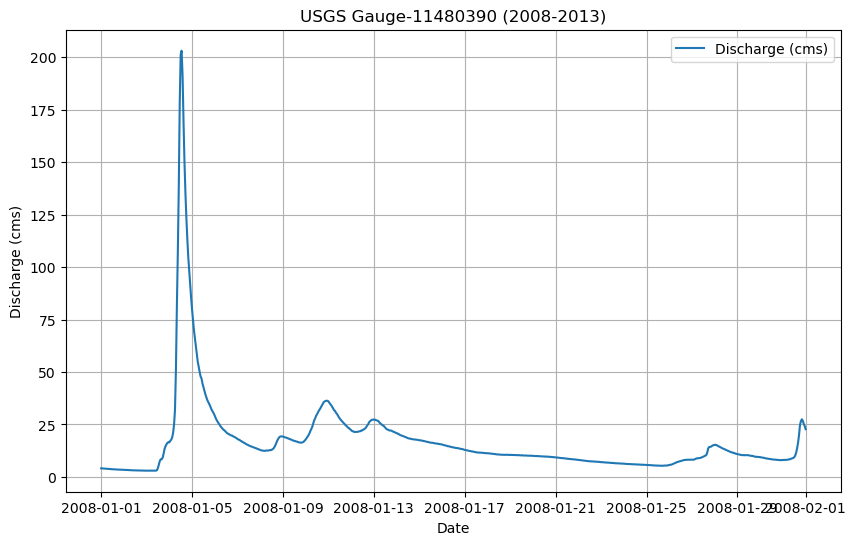

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the USGS observed streamflow CSV file
csv_file_path = 'observed.csv'

# Read the CSV file into a DataFrame
observed_streamflow = pd.read_csv(csv_file_path)

# Convert the 'date' column to a pandas datetime object
observed_streamflow['date'] = pd.to_datetime(observed_streamflow['date'])

# Filter the data for the specific date range
start_date = '2008-01-01'
end_date = '2008-02-01'
mask = (observed_streamflow['date'] >= start_date) & (observed_streamflow['date'] <= end_date)
filtered_streamflow = observed_streamflow[mask]

# Convert discharge from cubic feet per second (cfs) to cubic meters per second (cms)
filtered_streamflow['discharge_cms'] = filtered_streamflow['observation'] * 0.0283168

# Save the converted data to a new CSV file
output_file_path = 'observed_converted_filtered.csv'
filtered_streamflow.to_csv(output_file_path, index=False)

# Plot the discharge in cms against time
plt.figure(figsize=(10, 6))
plt.plot(filtered_streamflow['date'], filtered_streamflow['discharge_cms'], label='Discharge (cms)')
plt.xlabel('Date')
plt.ylabel('Discharge (cms)')
plt.title('USGS Gauge-11480390 (2008-2013)')
plt.legend()
plt.grid(True)
plt.show()



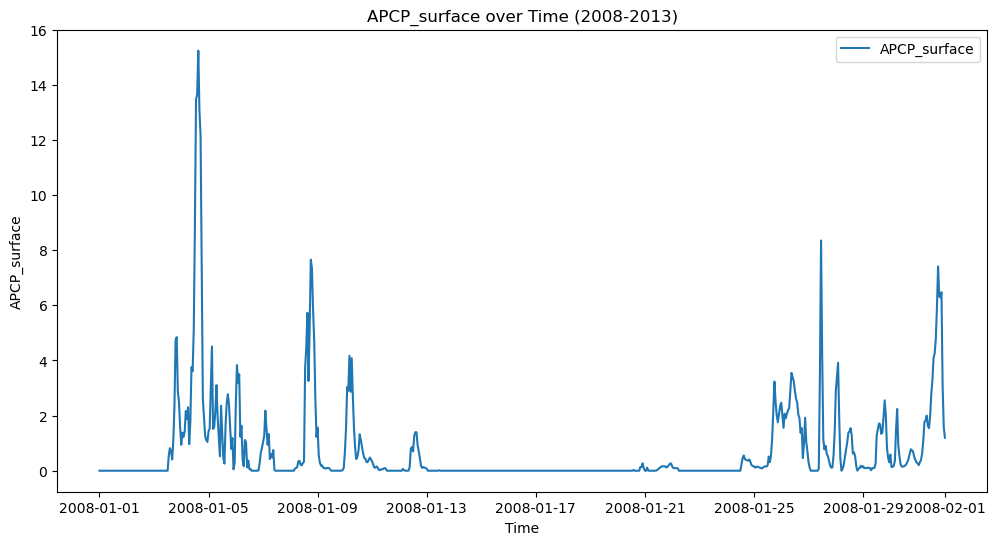

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new CSV file
file_path = 'cat58_01Dec2015.csv'
data = pd.read_csv(file_path)

# Ensure the 'time' column is in datetime format
data['time'] = pd.to_datetime(data['time'], format='%m/%d/%Y %H:%M')

# Filter the data for the specific date range
start_date = '2008-01-01'
end_date = '2008-02-01'
mask = (data['time'] >= start_date) & (data['time'] <= end_date)
filtered_data = data[mask]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['time'], filtered_data['APCP_surface'], label='APCP_surface')
plt.xlabel('Time')
plt.ylabel('APCP_surface')
plt.title('APCP_surface over Time (2008-2013)')
plt.legend()
plt.grid(False)
plt.show()



C:\Users\asatt\AppData\Local\Temp\ipykernel_6824\2335602445.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_observed_streamflow['discharge_cms'] = filtered_observed_streamflow['observation'] * 0.0283168


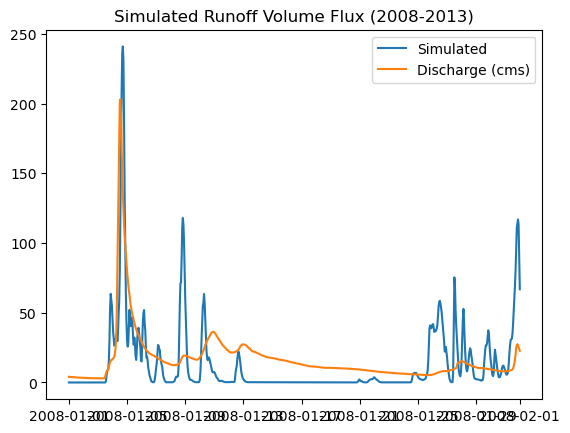

In [4]:
# Define the path to the USGS observed streamflow CSV file
observed_csv_file_path = 'observed.csv'
forcing_csv_file_path = 'cat58_01Dec2015.csv'

# Read the observed streamflow CSV file into a DataFrame
observed_streamflow = pd.read_csv(observed_csv_file_path)

# Convert the 'date' column to a pandas datetime object
observed_streamflow['date'] = pd.to_datetime(observed_streamflow['date'])

# Filter the observed data for the specific date range
start_date = '2008-01-01'
end_date = '2008-02-01'
observed_mask = (observed_streamflow['date'] >= start_date) & (observed_streamflow['date'] <= end_date)
filtered_observed_streamflow = observed_streamflow[observed_mask]

# Convert discharge from cubic feet per second (cfs) to cubic meters per second (cms)
filtered_observed_streamflow['discharge_cms'] = filtered_observed_streamflow['observation'] * 0.0283168

# Save the filtered and converted observed data to a new CSV file
filtered_observed_output_file_path = 'filtered_observed_converted.csv'
filtered_observed_streamflow.to_csv(filtered_observed_output_file_path, index=False)

# Read the forcing data CSV file into a DataFrame
df_forcing = pd.read_csv(forcing_csv_file_path)

# Ensure the 'time' column is in datetime format
df_forcing['time'] = pd.to_datetime(df_forcing['time'], format='%m/%d/%Y %H:%M')

# Filter the forcing data for the specific date range
forcing_mask = (df_forcing['time'] >= start_date) & (df_forcing['time'] <= end_date)
filtered_forcing = df_forcing[forcing_mask]

# Save the filtered forcing data to a new CSV file
filtered_forcing_output_file_path = 'filtered_forcing.csv'
filtered_forcing.to_csv(filtered_forcing_output_file_path, index=False)

# Initialize the CFE instance
cfe_instance = bmi_cfe.BMI_CFE('./cat58_config_cfe.json')
cfe_instance.initialize()

# Get output variable names
outputs = cfe_instance.get_output_var_names()
output_lists = {output: [] for output in outputs}

# Run the model for each precipitation value in the filtered forcing data
for precip in filtered_forcing['APCP_surface']:
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_instance.update()
    
    for output in outputs:
        output_lists[output].append(cfe_instance.get_value(output))

# Finalize the model
cfe_instance.finalize(print_mass_balance=False)

# Adjust the runoff volume flux by dividing by 3600
output_lists['land_surface_water__runoff_volume_flux'] = [value / 3600 for value in output_lists['land_surface_water__runoff_volume_flux']]
simulation = output_lists['land_surface_water__runoff_volume_flux']

# Plot the results
plt.plot(filtered_observed_streamflow['date'], output_lists['land_surface_water__runoff_volume_flux'], label="Simulated")
plt.plot(filtered_observed_streamflow['date'], filtered_observed_streamflow['discharge_cms'], label='Discharge (cms)')
plt.title('Simulated Runoff Volume Flux (2008-2013)')
plt.legend()
plt.show()
plt.close()


In [5]:
# Load the observed runoff data
observed_runoff = np.array(filtered_observed_streamflow['discharge_cms'])

# Ensure the simulation data is loaded correctly from the previous cell
simulated_runoff = np.array(simulation)

# Check for NaNs or infinite values
observed_has_nan_or_inf = np.isnan(observed_runoff).any() or np.isinf(observed_runoff).any()
simulated_has_nan_or_inf = np.isnan(simulated_runoff).any() or np.isinf(simulated_runoff).any()

print(f"Observed runoff has NaNs or infinite values: {observed_has_nan_or_inf}")
print(f"Simulated runoff has NaNs or infinite values: {simulated_has_nan_or_inf}")

# Print the number of observations before cleaning
print(f"Number of observed runoff values before cleaning: {len(observed_runoff)}")
print(f"Number of simulated runoff values before cleaning: {len(simulated_runoff)}")

# Remove NaNs or infinite values
mask = np.isfinite(observed_runoff) & np.isfinite(simulated_runoff)
observed_runoff_clean = observed_runoff[mask]
simulated_runoff_clean = simulated_runoff[mask]

# Print the number of observations after cleaning
print(f"Number of observed runoff values after cleaning: {len(observed_runoff_clean)}")
print(f"Number of simulated runoff values after cleaning: {len(simulated_runoff_clean)}")

# Calculate metrics
def nse(observed, simulated):
    return 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

def kge(observed, simulated):
    cc = np.corrcoef(observed, simulated)[0, 1]
    alpha = np.std(simulated) / np.std(observed)
    beta = np.mean(simulated) / np.mean(observed)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def rmse(observed, simulated):
    return np.sqrt(np.mean((observed - simulated) ** 2))

def pcc(observed, simulated):
    return pearsonr(observed, simulated)[0]

nse_value = nse(observed_runoff_clean, simulated_runoff_clean)
kge_value = kge(observed_runoff_clean, simulated_runoff_clean)
rmse_value = rmse(observed_runoff_clean, simulated_runoff_clean)
pcc_value = pcc(observed_runoff_clean, simulated_runoff_clean)

print(f"NSE: {nse_value}")
print(f"KGE: {kge_value}")
print(f"RMSE: {rmse_value}")
print(f"PCC: {pcc_value}")


Observed runoff has NaNs or infinite values: False
Simulated runoff has NaNs or infinite values: False
Number of observed runoff values before cleaning: 745
Number of simulated runoff values before cleaning: 745
Number of observed runoff values after cleaning: 745
Number of simulated runoff values after cleaning: 745
NSE: -0.15549613635045456
KGE: 0.45338543157559763
RMSE: 22.59104567943295
PCC: 0.6153435744837277
